### Vehicle Detection Project

The goals / steps of this project are the following:

   * Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
   * Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
   * Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
   * Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
   * Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
    Estimate a bounding box for vehicles detected.


### Module initializations

In [2]:
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label

import math
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import cv2
import glob
import time
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

%matplotlib inline



### Hog Featrue Detection

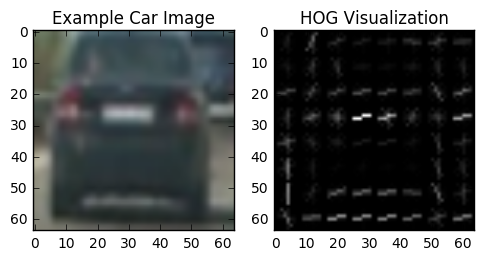

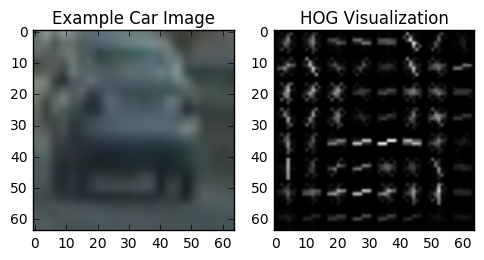

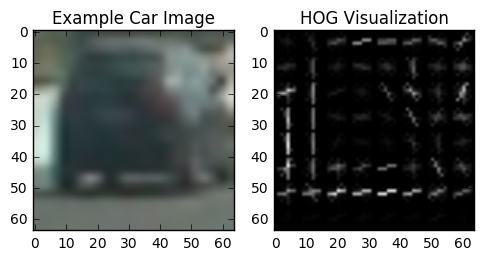

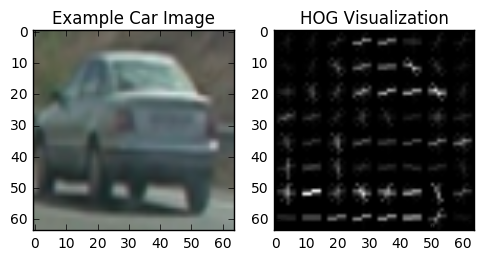

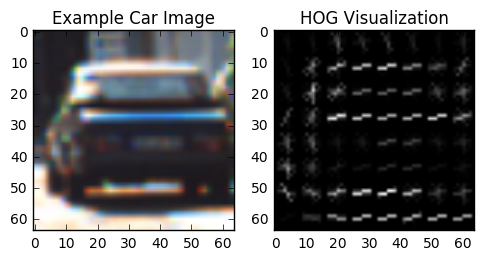

In [12]:
# Global variable for images data

image_data= [
    mpimg.imread('vehicles/GTI_MiddleClose/image0001.png'),
    mpimg.imread('vehicles/GTI_Far/image0030.png'),
    mpimg.imread('vehicles/GTI_Left/image0028.png'),
    mpimg.imread('vehicles/GTI_Right/image0041.png'),
    mpimg.imread('vehicles/KITTI_extracted/1.png'),
]

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    return hog(img, orientations=orient, 
                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                  cells_per_block=(cell_per_block, cell_per_block), 
                  transform_sqrt=True, 
                  visualise=vis, feature_vector=feature_vec)

ORIENT = 9  # HOG orientations
PIX_PER_CELL = 8 # HOG pixels per cell
CELL_PER_BLOCK = 2 # HOG cells per block

# Plot the examples
for image in image_data:
    # Call our function with vis=True to see an image output
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray, ORIENT, 
                        PIX_PER_CELL, CELL_PER_BLOCK, 
                        vis=True, feature_vec=False)

    fig = plt.figure(figsize = (15,15))
    plt.subplot(5,5,1)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image')
    plt.subplot(5,5,2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization')


### Binned & color features

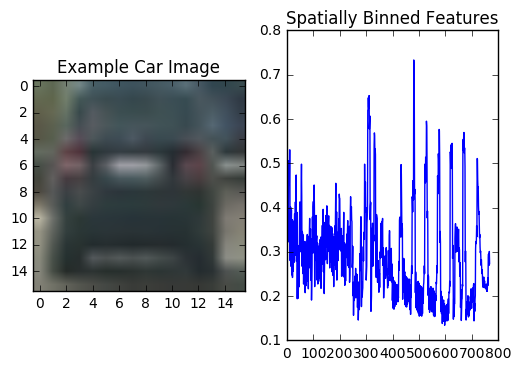

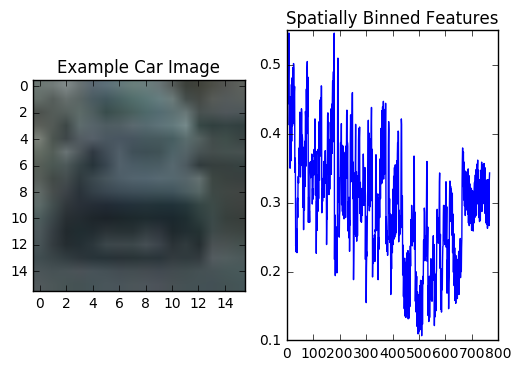

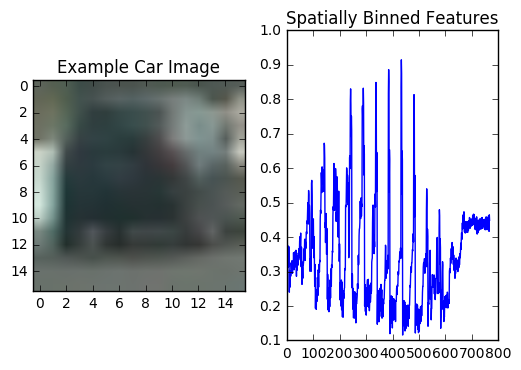

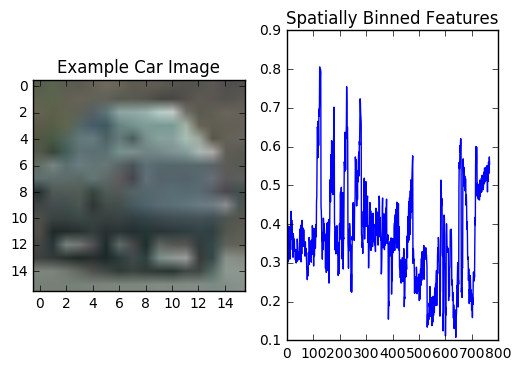

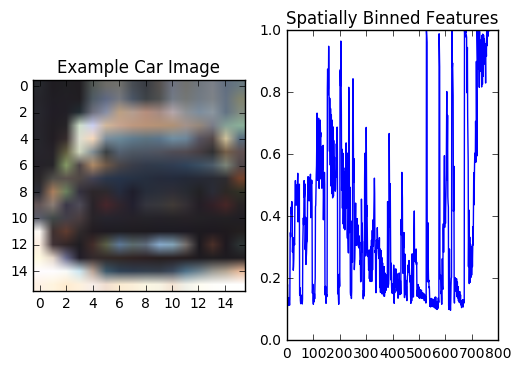

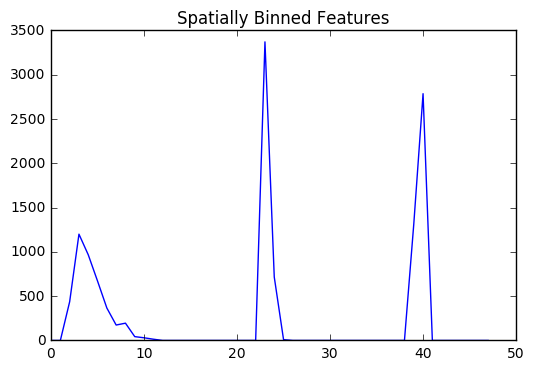

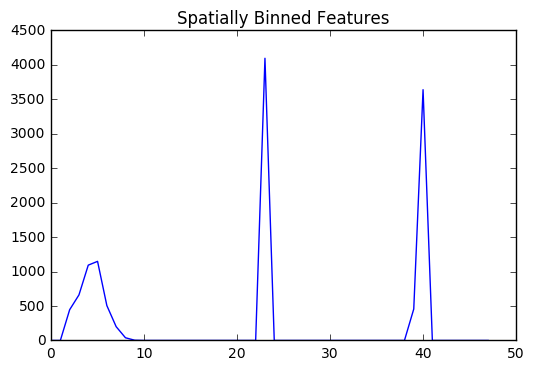

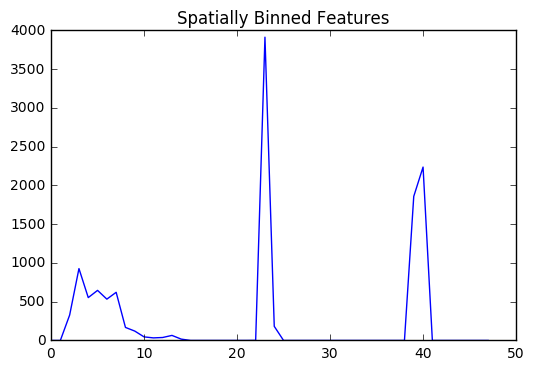

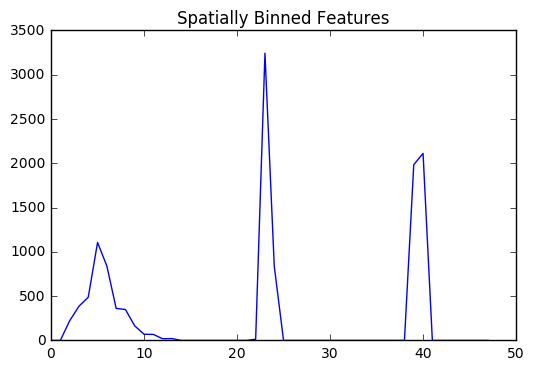

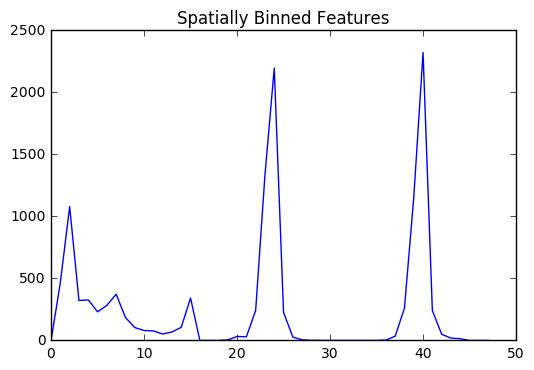

In [13]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


SPATIAL_SIZE = (16, 16)# Spatial binning dimensions

for image in image_data:
    vector = bin_spatial(image, SPATIAL_SIZE)

    # Plot features
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(cv2.resize(image, spatial_size))
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.plot(vector)
    plt.title('Spatially Binned Features')

    
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

HIST_BINS = 16    # Number of histogram bins

for image in image_data:
    feature_vec = color_hist(cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb), HIST_BINS)
    
    # Plot features
    plt.figure()
    plt.plot(feature_vec)
    plt.title('Spatially Binned Features')

### Extract features & Classifier training

In [20]:


# Define a function to extract features from a single image window

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

 

# Combine features together
def combine_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    all_features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        all_features.append(single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat))
        all_features.append(single_img_features(np.fliplr(image), color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat))
    # Return list of feature vectors
    return features

# Read in cars and notcars
cars = glob.glob('vehicles/**/*.png', recursive=True)
not_cars = glob.glob('non-vehicles/**/*.png', recursive=True)



# Global variables
# Flag declarations
color_space = 'YCrCb' 


hog_channel = 1
spatial_feat = True 
hist_feat = True 
hog_feat = True 

print("Extracting car features")
t=time.time()
car_features = combine_features(cars, color_space=color_space, 
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract...')
print("Extracting non_car features")
t=time.time()
notcar_features = combine_features(not_cars, color_space=color_space, 
                        spatial_size=SPATIAL_SIZE, hist_bins=HIST_BINS, 
                        orient=ORIENT, pix_per_cell=PIX_PER_CELL, 
                        cell_per_block=CELL_PER_BLOCK, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract...')


X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',ORIENT,'orientations',PIX_PER_CELL,
    'pixels per cell and', CELL_PER_BLOCK,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


Extracting car features
85.23 Seconds to extract...
Extracting non_car features
75.58 Seconds to extract...


ValueError: Found array with dim 5. StandardScaler expected <= 2.

In [ ]:
def stride_windows(img, win_size, num_win_x, y_top):
    x_right = img.shape[1] - win_size
    x_stride = int(round(x_right / (num_win_x-1)))
    windows = []
    for xs in range(num_win_x-1):
        windows.append(((xs*x_stride, y_top), (xs*x_stride+win_size, y_top+win_size)))
    # Make sure that the last window is pushed all the way to the edge
    windows.append(((x_right, y_top),(img.shape[1], y_top+win_size)))
    return windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    colors = [(0, 0, 255), (0, 255, 0)]
    for idx, bbox in enumerate(bboxes):
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], colors[idx%2], thick)
    # Return the image copy with boxes drawn
    return imcopy

def form_windows(image):
    windows = []
    coords = [
        (75, 40, 400),
        (120, 30, 390),
        (200, 10, 390),
        (220, 30, 350),
    ]
    for win_size, num_win_x, y_top in coords:
        windows.extend(stride_windows(image, win_size, num_win_x, y_top))
    return windows

images = glob.glob('test_images/test*.jpg')
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(30,30))
cnt = 0
for ax in axs:
    for x in ax:
        img = mpimg.imread(images[cnt])
        windows = form_windows(img)
        window_img = draw_boxes(img, windows, color=(0, 0, 255), thick=6) 
        # Convert to uint8 so that imshow displays properly
        x.imshow(window_img.astype(np.uint8))
        x.axis('off')
        cnt += 1
plt.show()

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows